# Section 1: Introduction and Setup

## 1.1 Project Overview
Research Aim - This study aims to examine how effective and practical neural network models are in optimising ETF portfolios to improve investment decision-making. This entails assessing the capability of neural networks to examine market data and individual investor profiles to create customised, data-based investment suggestions that manage risk and return in a changing financial environment.

## 1.2 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
import yfinance as yf

# Ensure that matplotlib plots are displayed inline in the Jupyter Notebook
%matplotlib inline

# Set seaborn as the default visualization library
sns.set()

## 1.3 Define Helper Functions

In [2]:
def plot_etf_performance(etf_data, title='ETF Performance'):
    """
    Plot the closing price and volume of an ETF.

    Parameters:
    etf_data (pandas.DataFrame): The ETF data.
    title (str): The title of the plot.
    """
    fig, ax1 = plt.subplots(figsize=(14, 7))

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close', color=color)
    ax1.plot(etf_data.index, etf_data['Close'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Volume', color=color)
    ax2.plot(etf_data.index, etf_data['Volume'], color=color, alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(title)
    plt.show()

# Section 2: Data Collection and Visualisation

## 2.1 Fetch ETF Data
This part includes a list of the top 5 ETFs by their tickers. We use the previously defined fetch_etf_data function to download historical data for these ETFs from Yahoo Finance from the year 2019 to 1st of January, 2024.

In [3]:
# List of 5 ETF tickers
etfs = ['SPY', 'GBTC', 'UUP', 'TECL', 'FNGU']

In [4]:
# Fetch data and ensure it's stored as a DataFrame
etf_data = {}
for etf in etfs:
    fetched_data = yf.download(etf, start='2019-01-01', end='2024-01-01')
    if not fetched_data.empty:
        # Explicitly confirm we're working with a DataFrame
        etf_data[etf] = pd.DataFrame(fetched_data)
        print(f"Data for {etf} fetched and stored as DataFrame.")
    else:
        print(f"No data fetched for {etf} or not available.")

[*********************100%%**********************]  1 of 1 completed


Data for SPY fetched and stored as DataFrame.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for GBTC fetched and stored as DataFrame.
Data for UUP fetched and stored as DataFrame.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for TECL fetched and stored as DataFrame.
Data for FNGU fetched and stored as DataFrame.


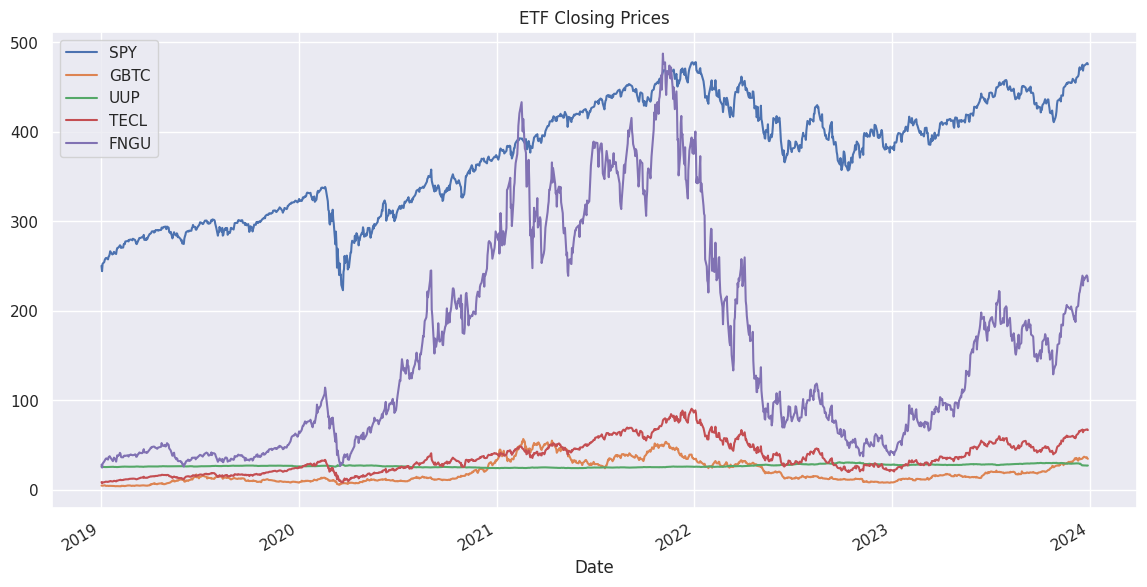

In [5]:
# Plot the closing prices
for etf in etfs:
    etf_data[etf]['Close'].plot(figsize=(14, 7), label=etf)

plt.title('ETF Closing Prices')
plt.legend()
plt.show()

In [6]:
etf_data[etf].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,25.100000,28.590000,25.000000,27.889999,27.889999,331200
2019-01-03,26.320000,26.900000,24.657000,24.799999,24.799999,209800
2019-01-04,26.120001,29.384001,26.100000,29.100000,29.100000,274100
2019-01-07,30.049999,31.910000,29.280001,31.610001,31.610001,258400
2019-01-08,33.060001,33.290001,30.219999,32.689999,32.689999,1143500


In [7]:
# Summary statistics for SPY
print(etf_data['SPY'].describe())

              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean    374.703323   377.046105   372.229428   374.805430   360.112243   
std      63.165059    63.256489    63.009835    63.142923    67.023815   
min     228.190002   229.679993   218.259995   222.949997   209.932602   
25%     313.872505   314.512497   311.182510   312.335007   292.963531   
50%     389.865005   392.330002   387.079987   389.750000   377.525955   
75%     429.244995   432.292488   426.367493   429.562508   417.966255   
max     479.220001   479.980011   476.260010   477.709991   475.213501   

             Volume  
count  1.258000e+03  
mean   8.418414e+07  
std    4.096124e+07  
min    2.027000e+07  
25%    5.894630e+07  
50%    7.556390e+07  
75%    9.589750e+07  
max    3.922207e+08  


## 2.2 Create Synthetic Investor Profiles
**Key Components of the Synthetic Investor Profiles:**

*   **Investor ID:** A unique identifier for each investor, ensuring anonymity and allowing for individual analysis without ethical concerns.
*   **Investment Horizon (Years):** Indicates the time frame the investor is looking at for their investment goals, impacting the choice of ETFs.
*   **Risk Tolerance:** Categorized as Low, Medium, or High, this attribute is crucial for portfolio optimization, dictating the level of risk an investor is willing to take.
*   **Investment Goal:** Specifies the primary objective of the investor's portfolio, such as Growth, Income, Preservation, or Speculation, guiding the selection and weighting of ETFs in the portfolio.

The introduction of synthetic investor IDs aligns with best practices for data privacy and ethical research, ensuring that our methodology respects the principles of responsible data handling. This anonymized dataset of investor profiles is instrumental in developing and testing the ETF Adviser Neural Network (ETFA-NN), aiming to deliver personalized investment recommendations that cater to the specific needs and preferences of diverse investor types.

In [8]:
!pip install faker

In [9]:
from faker import Faker
import random

fake = Faker()

In [10]:
def generate_investor_profiles(n):
    """
    Generate synthetic investor profiles with unique IDs.

    Parameters:
    n (int): The number of investor profiles to generate.

    Returns:
    pandas.DataFrame: A DataFrame containing the synthetic investor profiles.
    """
    profiles = []
    risk_tolerances = ['low', 'medium', 'high']
    investment_goals = ['preserve capital', 'balanced growth', 'aggressive growth']
    time_horizons = ['short', 'medium', 'long']

    for _ in range(n):
        profile = {
            'investor_id': fake.uuid4(),
            'risk_tolerance': random.choice(risk_tolerances),
            'investment_goal': random.choice(investment_goals),
            'time_horizon': random.choice(time_horizons)
        }
        profiles.append(profile)

    return profiles

In [11]:
# Generate 150 synthetic investor profiles
investor_profiles = generate_investor_profiles(150)
# Convert to DataFrame for easier manipulation and visualization
investor_profiles_df = pd.DataFrame(investor_profiles)
investor_profiles_df.head()

,investor_id,risk_tolerance,investment_goal,time_horizon
0,78b1c903-4c8d-4684-a019-2ea40a7e823b,high,preserve capital,long
1,105cdc0a-0990-484e-a8da-d051286d9ed6,medium,aggressive growth,medium
2,7f55543b-33eb-46e2-acd3-9555de0d05b0,high,aggressive growth,short
3,74172eea-9b57-4a44-acba-49625909ff6e,medium,aggressive growth,medium
4,57764206-aa83-4caa-a7cd-aeb763948456,low,preserve capital,short


## 2.3 Exploratory Data Analysis
*  Visualization 2.1: A horizontal bar chart that shows the top 20 ETFs by their average daily trading volume, giving an insight into their liquidity and popularity.

*  Visualization 2.2: A count plot that displays the distribution of synthetic investor profiles according to their risk tolerance, illustrating the diversity in investor risk preferences within your synthetic dataset.

### Visualization 2.1: ETF Selection Overview
A horizontal bar chart that shows the ETFs by their average daily trading volume, giving an insight into their liquidity and popularity.

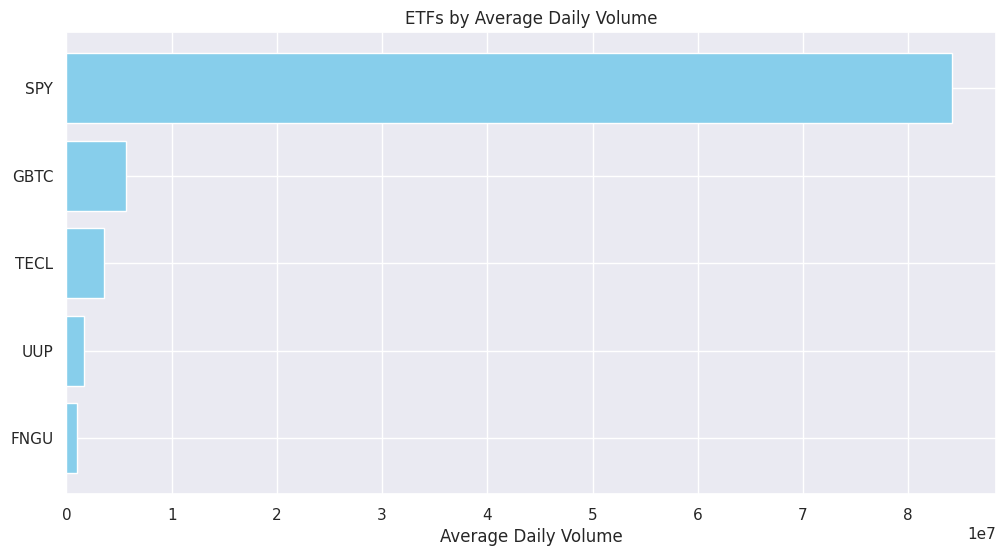

In [12]:
plt.figure(figsize=(12, 6))
etf_volumes = [etf_data[ticker]['Volume'].mean() for ticker in etfs]
etf_volumes_sorted, etf_sorted = zip(*sorted(zip(etf_volumes, etfs)))
plt.barh(etf_sorted, etf_volumes_sorted, color='skyblue')
plt.xlabel('Average Daily Volume')
plt.title('ETFs by Average Daily Volume')
plt.show()

### Visualization 2.2: Investor Profile Distribution by Risk Tolerance
A count plot that displays the distribution of synthetic investor profiles according to their risk tolerance, illustrating the diversity in investor risk preferences within your synthetic dataset.

<ipython-input-13-3f4dadfb9bbf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_tolerance', data=investor_profiles_df, palette='viridis')


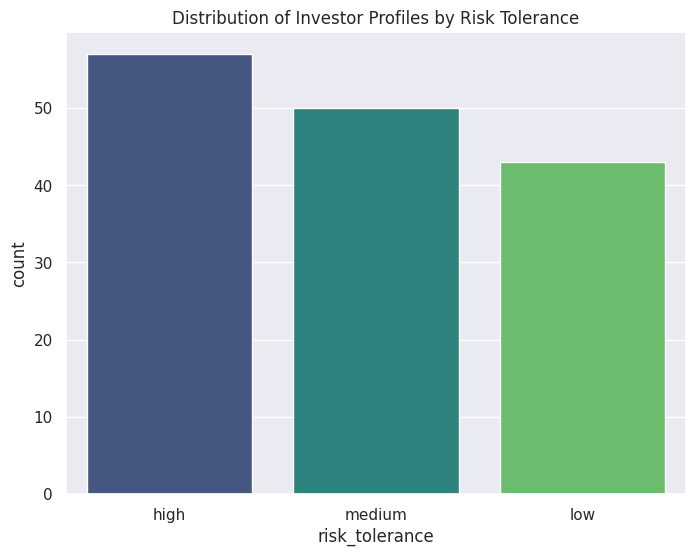

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='risk_tolerance', data=investor_profiles_df, palette='viridis')
plt.title('Distribution of Investor Profiles by Risk Tolerance')
plt.show()

### Visualization 2.3: Correlation Heatmap of ETFs
If analyzing multiple ETFs, a heatmap can help identify how their movements are correlated, which is useful for diversification strategies. This visualization presents a heatmap of the correlation matrix for the ETFs based on their closing prices.

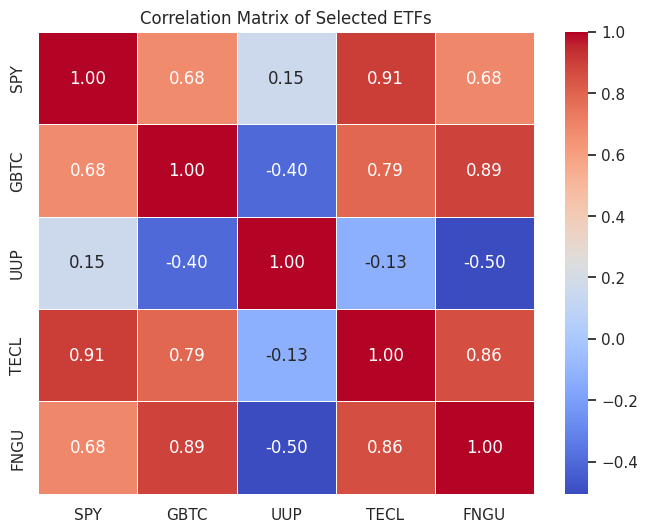

In [14]:
# Combine closing prices into a single DataFrame
closing_prices = pd.DataFrame({ticker: etf_data[ticker]['Close'] for ticker in etfs})

# Calculate the correlation matrix
correlation_matrix = closing_prices.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected ETFs')
plt.show()

[*********************100%%**********************]  1 of 1 completed


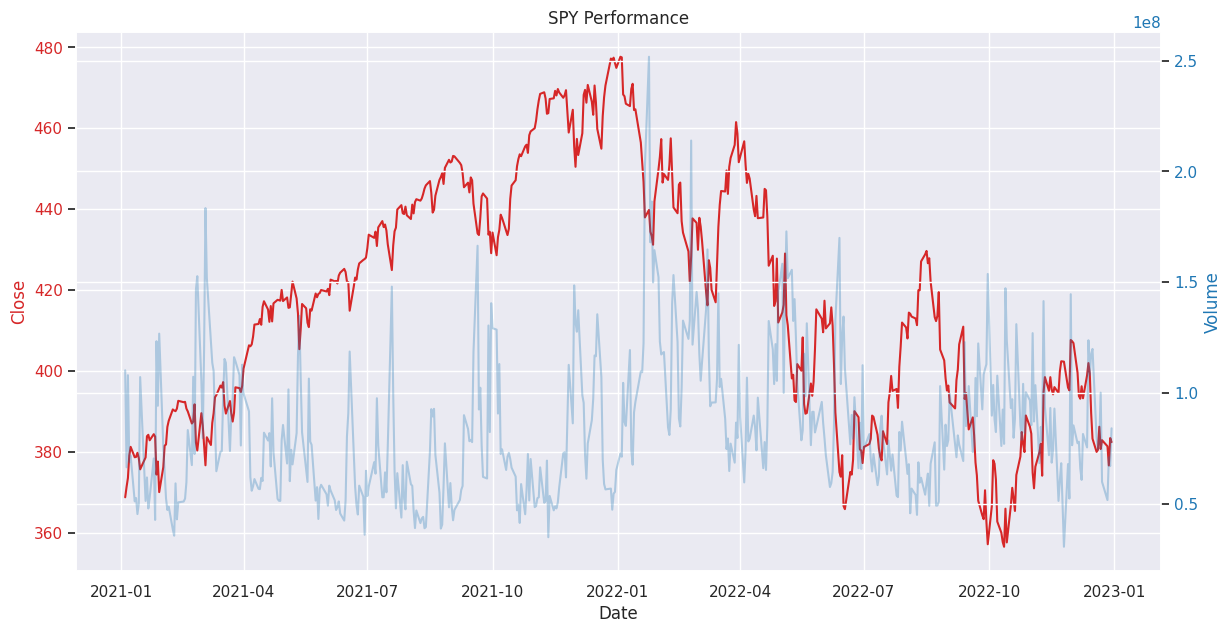

In [15]:
sample_etf_ticker = 'SPY'
etf_data = yf.download(sample_etf_ticker, start='2021-01-01', end='2023-01-01')

plot_etf_performance(etf_data, title=f'{sample_etf_ticker} Performance')

# Section 3: Data Preprocessing and Integration

## 3.1 Data Integration for Multiple ETFs
For each ETF, we will integrate its data with the investor profiles. This involves selecting key features from each ETF's dataset and combining them with the investor profiles. To manage complexity, let's focus on a simplified feature set for each ETF, such as closing price and volume.

### 3.1.1 Compute Metrics for Each ETF
First, we need to calculate the metrics we'll use to categorize ETFs. Volatility can represent risk, and the compound annual growth rate (CAGR) can represent the long-term return, aligning with investment goals.

In [16]:
# Fetch data and ensure it's stored as a DataFrame
etf_data = {}
for etf in etfs:
    fetched_data = yf.download(etf, start='2020-01-01', end='2023-01-01')
    if not fetched_data.empty:
        # Explicitly confirm we're working with a DataFrame
        etf_data[etf] = pd.DataFrame(fetched_data)
        print(f"Data for {etf} fetched and stored as DataFrame.")
    else:
        print(f"No data fetched for {etf} or not available.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for SPY fetched and stored as DataFrame.
Data for GBTC fetched and stored as DataFrame.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data for UUP fetched and stored as DataFrame.
Data for TECL fetched and stored as DataFrame.
Data for FNGU fetched and stored as DataFrame.


In [17]:
def calculate_cagr(df):
    """Calculate the Compound Annual Growth Rate (CAGR) for an ETF."""
    start_value = df['Close'].iloc[0]
    end_value = df['Close'].iloc[-1]
    num_years = (df['Close'].index[-1] - df['Close'].index[0]).days / 365.25
    return (end_value / start_value) ** (1 / num_years) - 1

# Calculate daily returns and volatility for each ETF
for etf in etfs:
    # Calculate daily returns
    etf_data[etf]['daily_returns'] = etf_data[etf]['Close'].pct_change()
    # Calculate annualized volatility (standard deviation of daily returns * sqrt(252))
    etf_data[etf]['annualized_volatility'] = etf_data[etf]['daily_returns'].std() * np.sqrt(252)
    # Calculate CAGR
    etf_data[etf]['CAGR'] = calculate_cagr(etf_data[etf])

In [18]:
etf_data[etf].head()

,Open,High,Low,Close,Adj Close,Volume,daily_returns,annualized_volatility,CAGR
Date,,,,,,,,,
2020-01-02,62.119999,65.209999,62.080002,65.209999,65.209999,155900,NaN,1.0739,-0.128016
2020-01-03,63.000000,64.747002,62.651001,63.320000,63.320000,190100,-0.028983,1.0739,-0.128016
2020-01-06,61.389999,65.904999,61.240002,65.879997,65.879997,175300,0.040430,1.0739,-0.128016
2020-01-07,66.800003,68.074997,65.660004,67.279999,67.279999,206300,0.021251,1.0739,-0.128016
2020-01-08,67.309998,71.209999,67.110001,69.900002,69.900002,242700,0.038942,1.0739,-0.128016


In [19]:
etf_data[etf].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-01-02 to 2022-12-30
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   756 non-null    float64
 1   High                   756 non-null    float64
 2   Low                    756 non-null    float64
 3   Close                  756 non-null    float64
 4   Adj Close              756 non-null    float64
 5   Volume                 756 non-null    int64  
 6   daily_returns          755 non-null    float64
 7   annualized_volatility  756 non-null    float64
 8   CAGR                   756 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 59.1 KB


In [20]:
etf_data[etf] = etf_data[etf].dropna()

### 3.1.2 Define Matching Criteria
To match ETFs to investor profiles, define criteria based on the computed metrics. For example, categorize ETFs as 'low', 'medium', or 'high' risk based on volatility thresholds and 'low', 'medium', or 'high' growth based on CAGR thresholds.

In [21]:
def categorize_etf(volatility, cagr):
    # Define thresholds for simplicity; these would be determined based on deeper analysis
    vol_thresholds = {'low': 0.1, 'medium': 0.2, 'high': 0.3}
    cagr_thresholds = {'low': 0.05, 'medium': 0.1, 'high': 0.15}

    risk_category = 'high'
    if volatility <= vol_thresholds['low']:
        risk_category = 'low'
    elif volatility <= vol_thresholds['medium']:
        risk_category = 'medium'

    growth_category = 'high'
    if cagr <= cagr_thresholds['low']:
        growth_category = 'low'
    elif cagr <= cagr_thresholds['medium']:
        growth_category = 'medium'

    return risk_category, growth_category

# Apply categorization to each ETF
etf_categories = {}
for etf in etfs:
    vol = etf_data[etf]['annualized_volatility'].iloc[-1]
    cagr = etf_data[etf]['CAGR'].iloc[-1]
    etf_categories[etf] = categorize_etf(vol, cagr)

print(etf_categories)

{'SPY': ('high', 'medium'), 'GBTC': ('high', 'low'), 'UUP': ('low', 'low'), 'TECL': ('high', 'low'), 'FNGU': ('high', 'low')}


### 3.1.3 Dynamically Match ETFs to Investor Profiles
Using the categories assigned to each ETF, we can match them to investor profiles based on their risk tolerance and investment goals. This involves mapping the 'risk_category' and 'growth_category' to the investor's 'risk_tolerance' and 'investment_goal'.

In [22]:
# Modify the match_etfs_to_investor function to use actual investor attributes
def match_etfs_to_investor(profile, etf_categories):
    risk_tolerance = profile['risk_tolerance']
    # Mapping investment goals to growth categories for simplicity
    investment_goal_mapping = {'preserve capital': 'low',
                               'balanced growth': 'medium',
                               'aggressive growth': 'high'}
    investment_goal = investment_goal_mapping[profile['investment_goal']]

    matched_etfs = []
    for etf, (risk_category, growth_category) in etf_categories.items():
        if risk_category == risk_tolerance and growth_category == investment_goal:
            matched_etfs.append(etf)
    return matched_etfs

# Assuming investor_profiles_df is the DataFrame containing all investor profiles
# and etf_categories is a dictionary with ETFs as keys and tuples (risk_category, growth_category) as values

# Add a new column to investor_profiles_df for matched ETFs
investor_profiles_df['matched_etfs'] = investor_profiles_df.apply(lambda row: match_etfs_to_investor(row, etf_categories), axis=1)

print(investor_profiles_df[['investor_id', 'risk_tolerance', 'investment_goal', 'matched_etfs']])

                              investor_id risk_tolerance    investment_goal  \
0    78b1c903-4c8d-4684-a019-2ea40a7e823b           high   preserve capital   
1    105cdc0a-0990-484e-a8da-d051286d9ed6         medium  aggressive growth   
2    7f55543b-33eb-46e2-acd3-9555de0d05b0           high  aggressive growth   
3    74172eea-9b57-4a44-acba-49625909ff6e         medium  aggressive growth   
4    57764206-aa83-4caa-a7cd-aeb763948456            low   preserve capital   
..                                    ...            ...                ...   
145  5c6d1f3b-8654-4e4d-b671-723a55f63e00         medium   preserve capital   
146  236ca26c-6f1e-4695-991c-97223a63f388           high  aggressive growth   
147  ef3952f0-9fb1-4eae-be6b-53b6cd0a7a9d           high   preserve capital   
148  d6a62ddd-7ef5-4580-b920-011afe2e0172            low   preserve capital   
149  2920185c-d1a0-4d7f-b829-006bf3128e64         medium  aggressive growth   

           matched_etfs  
0    [GBTC, TECL, FNGU]  

In [23]:
investor_profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   investor_id      150 non-null    object
 1   risk_tolerance   150 non-null    object
 2   investment_goal  150 non-null    object
 3   time_horizon     150 non-null    object
 4   matched_etfs     150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB


## 3.2 Feature Engineering

### Calculating Future Returns
Calculating future returns is a critical step before model training, as it establishes the target variable our models will predict. For simplicity, let's focus on calculating simple future returns over a specific horizon, which is common in financial modeling for portfolio optimization and investment strategy development.
The future return of an ETF can be calculated as the percentage change in its price over your chosen horizon.

We'll also be enhancing the feature preparation to include a binary classification target indicating whether the price will go up or down.
This function adds a 'Price_Up' column to your ETF DataFrame, indicating with a 1 or 0 whether the price is expected to increase or decrease over the specified future period.

In [24]:
def calculate_future_returns(etf_df, horizon=5):
    """
    Calculates future returns over a specified horizon.

    Parameters:
    - etf_df: DataFrame containing the ETF's historical data.
    - horizon: The number of days ahead for which the return is calculated.

    Returns:
    - The original DataFrame with an additional column for future returns.
    """
    # Calculate the future price after the given horizon
    etf_df['future_price'] = etf_df['Close'].shift(-horizon)

    # Calculate the future return as percentage change between the future price and the current close price
    etf_df['future_return'] = (etf_df['future_price'] - etf_df['Close']) / etf_df['Close']

    # Determine if the future price is higher than the current price
    etf_df['price_up'] = (etf_df['future_price'] > etf_df['Close']).astype(int)

    return etf_df.dropna()

# Apply the function to calculate future returns for each ETF
for etf in etfs:
    etf_data[etf] = calculate_future_returns(etf_data[etf])

In [25]:
etf_data[etf].tail()

,Open,High,Low,Close,Adj Close,Volume,daily_returns,annualized_volatility,CAGR,future_price,future_return,price_up
Date,,,,,,,,,,,,
2022-12-16,52.000000,53.118999,49.516998,49.849998,49.849998,1611000,-0.026747,1.0739,-0.128016,43.889999,-0.119559,0
2022-12-19,49.500000,49.880001,46.049999,46.810001,46.810001,2047500,-0.060983,1.0739,-0.128016,39.759998,-0.150609,0
2022-12-20,45.240002,47.820000,44.417999,46.450001,46.450001,2030000,-0.007691,1.0739,-0.128016,38.590000,-0.169214,0
2022-12-21,47.070000,50.328999,46.200001,49.430000,49.430000,2430800,0.064155,1.0739,-0.128016,42.869999,-0.132713,0
2022-12-22,47.040001,47.400002,41.130001,43.810001,43.810001,3182200,-0.113696,1.0739,-0.128016,43.279999,-0.012098,0


### 3.2.1 Data Preparation for Multiple ETFs
First, we need to prepare the feature set and target variable for each matched ETF across all investor profiles. Assuming you've calculated future returns as your target variable and decided on the set of features (e.g., lagged returns, volume), the preparation involves creating these features for each ETF in your dataset.

In [26]:
def prepare_features(etf_symbol, etf_data, lags=5):
    """
    Prepares lagged features and the target variable for the specified ETF.

    Parameters:
    - etf_symbol: The symbol for the ETF.
    - etf_data: A dictionary containing historical data DataFrames for each ETF.
    - lags: The number of lagged days to use as features.

    Returns:
    - A DataFrame with features and the target variable for the specified ETF.
    """
    # Ensure the ETF data is sorted by date
    etf_df = etf_data[etf_symbol].sort_index()

    # Generate lagged features
    for lag in range(1, lags + 1):
        etf_df[f'lag_{lag}_close'] = etf_df['Close'].shift(lag)

    # Assuming 'future_return' is already calculated in your dataset
    # Drop rows with NaN values introduced by shifting
    etf_df.dropna(inplace=True)

    return etf_df

# Prepare features for all ETFs in the dataset
for etf in etfs:
    etf_data[etf] = prepare_features(etf, etf_data)

In [27]:
etf_data[etf].head()

,Open,High,Low,Close,Adj Close,Volume,daily_returns,annualized_volatility,CAGR,future_price,future_return,price_up,lag_1_close,lag_2_close,lag_3_close,lag_4_close,lag_5_close
Date,,,,,,,,,,,,,,,,,
2020-01-10,72.309998,72.779999,70.769997,71.470001,71.470001,189300,-0.001258,1.0739,-0.128016,75.885002,0.061774,1,71.559998,69.900002,67.279999,65.879997,63.320000
2020-01-13,74.169998,76.360001,73.011002,76.360001,76.360001,249700,0.068420,1.0739,-0.128016,76.739998,0.004976,1,71.470001,71.559998,69.900002,67.279999,65.879997
2020-01-14,77.099998,77.477997,73.925003,74.800003,74.800003,318500,-0.020430,1.0739,-0.128016,76.955002,0.028810,1,76.360001,71.470001,71.559998,69.900002,67.279999
2020-01-15,74.510002,75.847000,73.250000,73.970001,73.970001,215600,-0.011096,1.0739,-0.128016,78.209999,0.057321,1,74.800003,76.360001,71.470001,71.559998,69.900002
2020-01-16,74.500000,75.070000,73.010002,75.070000,75.070000,162300,0.014871,1.0739,-0.128016,75.320000,0.003330,1,73.970001,74.800003,76.360001,71.470001,71.559998


### 3.2.2 Model Selection and Training for Each Investor Profile
Now, we'll iterate over each investor profile, train models for their matched ETFs, and store the models for future evaluation.

In [28]:
etf_data[etf].columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'daily_returns',
       'annualized_volatility', 'CAGR', 'future_price', 'future_return',
       'price_up', 'lag_1_close', 'lag_2_close', 'lag_3_close', 'lag_4_close',
       'lag_5_close'],
      dtype='object')

In [29]:
investor_profiles_df.columns

Index(['investor_id', 'risk_tolerance', 'investment_goal', 'time_horizon',
       'matched_etfs'],
      dtype='object')

In [30]:
# Initialize a dictionary to store models for each investor
reg_investor_models = {}

# Function to train regressor models for all investor profiles
def train_reg_models(investor_profiles_df, etf_data):
    for index, investor_profile in investor_profiles_df.iterrows():
        investor_id = investor_profile['investor_id']
        matched_etfs = investor_profile['matched_etfs']
        investor_models = {}

        for etf in matched_etfs:
            # Prepare the data for the ETF
            X = etf_data[etf].drop(['future_price','future_return'], axis=1)
            y = etf_data[etf]['future_return']

            # Split the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Train GBM and RF models
            gbm = GradientBoostingRegressor(random_state=42)
            rf = RandomForestRegressor(random_state=42)
            gbm.fit(X_train, y_train)
            rf.fit(X_train, y_train)

            # Store the models
            investor_models[etf] = {'GBM': gbm, 'RF': rf}

            # Evaluate models (optional)
            for model_name, model in investor_models[etf].items():
              predictions = model.predict(X_test)
              mse = mean_squared_error(y_test, predictions)
              print(f"{etf} - {model_name} MSE: {mse}")

        # Store models for the investor
        reg_investor_models[investor_id] = investor_models

In [31]:
# Execute the function
train_reg_models(investor_profiles_df, etf_data)

GBTC - GBM MSE: 0.007259498598612289
GBTC - RF MSE: 0.007382204475236821
TECL - GBM MSE: 0.005327976895007795
TECL - RF MSE: 0.005371217051153031
FNGU - GBM MSE: 0.009615523013781765
FNGU - RF MSE: 0.00961122487861574
UUP - GBM MSE: 5.2387558048174834e-05
UUP - RF MSE: 5.1169107473395984e-05
GBTC - GBM MSE: 0.007259498598612289
GBTC - RF MSE: 0.007382204475236821
TECL - GBM MSE: 0.005327976895007795
TECL - RF MSE: 0.005371217051153031
FNGU - GBM MSE: 0.009615523013781765
FNGU - RF MSE: 0.00961122487861574
GBTC - GBM MSE: 0.007259498598612289
GBTC - RF MSE: 0.007382204475236821
TECL - GBM MSE: 0.005327976895007795
TECL - RF MSE: 0.005371217051153031
FNGU - GBM MSE: 0.009615523013781765
FNGU - RF MSE: 0.00961122487861574
UUP - GBM MSE: 5.2387558048174834e-05
UUP - RF MSE: 5.1169107473395984e-05
SPY - GBM MSE: 0.0004787583674111268
SPY - RF MSE: 0.0004323038790563801
SPY - GBM MSE: 0.0004787583674111268
SPY - RF MSE: 0.0004323038790563801
SPY - GBM MSE: 0.0004787583674111268
SPY - RF MSE:

In [32]:
cls_investor_models = {}

# Function to train classifier models for all investor profiles
def train_class_models(investor_profiles_df, etf_data):
    for index, investor_profile in investor_profiles_df.iterrows():
        investor_id = investor_profile['investor_id']
        matched_etfs = investor_profile['matched_etfs']

        for etf in matched_etfs:
          # Splitting the dataset into features and target
          X = etf_data[etf].drop(['future_price','future_return','price_up'], axis=1)
          y = etf_data[etf]['price_up']

          # Split the data into training and testing sets
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

          # Intialize classifiers
          models = {
              "Random Forest": RandomForestClassifier(random_state=42),
              "Gradient Boosting": GradientBoostingClassifier(random_state=42)
          }

          # Dictionary to store evaluation results
          results = {}

          # Train and evaluate each model
          for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)

            results[name] = {
                "model": model,
                "accuracy": accuracy,
                "classification_report": class_report
            }

            print(f"Results for {name}:")
            print(f"Accuracy: {accuracy}")
            print("Classification Report:")
            print(class_report)

          return results

In [33]:
# Executing the function
results = train_class_models(investor_profiles_df, etf_data)

Results for Random Forest:
Accuracy: 0.5704697986577181
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.58        73
           1       0.59      0.53      0.56        76

    accuracy                           0.57       149
   macro avg       0.57      0.57      0.57       149
weighted avg       0.57      0.57      0.57       149

Results for Gradient Boosting:
Accuracy: 0.5973154362416108
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58        73
           1       0.60      0.62      0.61        76

    accuracy                           0.60       149
   macro avg       0.60      0.60      0.60       149
weighted avg       0.60      0.60      0.60       149



# Section 4: Hybrid Neural Network

## 4.1 Neural Network Design
For the design of the hybrid neural network, using TensorFlow's Keras API; I used this architecture:
*     **Input Layer**: The Input layer specifies the shape of the input data which corresponds to the number of features my dataset contains.
*     **Shared LSTM Layers**: These layers are used for capturing the sequences in the time-series data. The LSTM layers are particularly useful for financial time series data due to their ability to remember past information. Dropout is used to prevent overfitting.
*     **Shared Dense Layer**: A dense layer that processes features extracted by LSTMs, making the subsequent outputs available for both branches.
*     **Regression Branch**: This branch ends with a dense layer with a single neuron (Dense(1)) using a linear activation function, suitable for predicting continuous output (e.g., future returns).
*     **Classification Branch**: Ends with a dense layer designed for classification (Dense(number_of_classes)), using a softmax activation for binary classification.
*     **Model Compilation**: A dense layer that processes features extracted by LSTMs, making the subsequent outputs available for both branches.
        1.   The model is compiled with ***'adam'*** optimizer.
        2.   Loss functions are specified for each output - Mean Squared Error for the regression output and Categorical Crossentropy for the classification output.
        3.   Metrics for monitoring are also defined separately for each branch.

This setup ensures that your neural network can handle both regression and classification tasks simultaneously, tailored to meet the specific needs of ETF investment strategy development and evaluation.

In [43]:
# Input Layer
input_layer = Input(shape=(time_steps, features_per_step))

# Define the LSTM network
lstm_layer = LSTM(64, return_sequences=True)(input_layer)
lstm_layer = Dropout(0.2)(lstm_layer)
lstm_layer = LSTM(32)(lstm_layer)

# Define output layers for regression and classification
regression_output = Dense(1, activation='linear',
                          name='regression_output')(lstm_layer)
classification_output = Dense(1, activation='sigmoid',
                              name='classification_output')(lstm_layer)

# Construct the model
model = Model(inputs=input_layer, outputs=[regression_output,
                                           classification_output])

# Model Compilation
model.compile(
    optimizer='adam',
    loss={
        'regression_output': 'mean_squared_error',
        'classification_output': 'categorical_crossentropy'
    },
    metrics={
        'regression_output': ['mean_squared_error'],
        'classification_output': ['accuracy']
    }
)

# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3, 3)]               0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 3, 64)                17408     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 3, 64)                0         ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['dropout[0][0]']             
                                                                                              

## 4.2 Neural Network Training
For the hybrid neural network, the ETF data will primarily be used to train the model since it includes both features (inputs) and targets (outputs) required for the tasks of regression and classification.

The investor profiles, while important for defining which ETFs to recommend based on individual preferences, might not directly feed into the initial training of the neural network. Instead, they could be used post-training to filter or prioritize the model outputs according to individual investor profiles.

### 4.2.1 Extracting Necessary Columns
I'll be splitting the dataset appropriately into features and targets.

In [37]:
# 'etf_data' is a dictionary where each key is an ETF and each value is a DataFrame
# let's consider 'etf' is one of the keys from etf_data dictionary

# Selecting features - include lagged prices, daily returns, volatility, CAGR, and Volume
features = etf_data[etf][['lag_1_close', 'lag_2_close',
                          'lag_3_close', 'lag_4_close',
                          'lag_5_close', 'daily_returns',
                          'annualized_volatility', 'CAGR', 'Volume']].values

# Regression target - future return
regression_target = etf_data[etf]['future_return'].values

# Classification target - price going up (1) or not (0)
classification_target = etf_data[etf]['price_up'].values


### 4.2.2 Data Normalization
Scaling the features to make training more stable and efficient.

In [38]:
from sklearn.preprocessing import StandardScaler

# Splitting the dataset into training and testing
X_train, X_test, y_train_reg, y_test_reg, y_train_cls, y_test_cls = train_test_split(
    features,
    regression_target,
    classification_target,
    test_size=0.2,
    random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [39]:
time_steps = 5  # Number of sequential points in time
features_per_step = X_train.shape[1] // time_steps  # Assuming this divides evenly


In [40]:
if (X_train.shape[1] == time_steps * features_per_step):
    X_train_reshaped = X_train.reshape((-1, time_steps, features_per_step))
    X_test_reshaped = X_test.reshape((-1, time_steps, features_per_step))
else:
    raise ValueError("The product of time_steps and features_per_step does not match the total features")

ValueError: The product of time_steps and features_per_step does not match the total features

In [41]:
print("Expected reshape dimensions:", (-1, time_steps, features_per_step))
print("Original shape:", X_train.shape)

Expected reshape dimensions: (-1, 5, 1)
Original shape: (596, 9)


In [42]:
time_steps = 3
features_per_step = 3  # 9 total features divided into 3 timesteps

# Reshape the data
X_train_reshaped = X_train.reshape((-1, time_steps, features_per_step))
X_test_reshaped = X_test.reshape((-1, time_steps, features_per_step))

# Verify new shape
print("New reshaped train data:", X_train_reshaped.shape)
print("New reshaped test data:", X_test_reshaped.shape)


New reshaped train data: (596, 3, 3)
New reshaped test data: (149, 3, 3)


### 4.2.3 Model Training
Finally, I'll push the prepared data into the model for training.

In [44]:
# Model Training
history = model.fit(
    X_train_reshaped,
    {'regression_output': y_train_reg, 'classification_output': y_train_cls},
    validation_data=(X_test_reshaped, {'regression_output': y_test_reg, 'classification_output': y_test_cls}),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


19/19 [==============================] - 6s 63ms/step - loss: 0.0388 - regression_output_loss: 0.0388 - classification_output_loss: 0.0000e+00 - regression_output_mean_squared_error: 0.0388 - classification_output_accuracy: 0.4849 - val_loss: 0.0217 - val_regression_output_loss: 0.0217 - val_classification_output_loss: 0.0000e+00 - val_regression_output_mean_squared_error: 0.0217 - val_classification_output_accuracy: 0.4631
Epoch 2/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0295 - regression_output_loss: 0.0295 - classification_output_loss: 0.0000e+00 - regression_output_mean_squared_error: 0.0295 - classification_output_accuracy: 0.4815 - val_loss: 0.0218 - val_regression_output_loss: 0.0218 - val_classification_output_loss: 0.0000e+00 - val_regression_output_mean_squared_error: 0.0218 - val_classification_output_accuracy: 0.4631
Epoch 3/50
19/19 [==============================] - 0s 10ms/step - loss: 0.0277 - regression_output_loss: 0.0277 - classification_outp

### 4.2.4 Monitoring Training Progress
It's useful to visualize the training progress to diagnose issues like overfitting or underfitting. Plotting the training and validation loss over epochs can help you understand how well the model is learning.

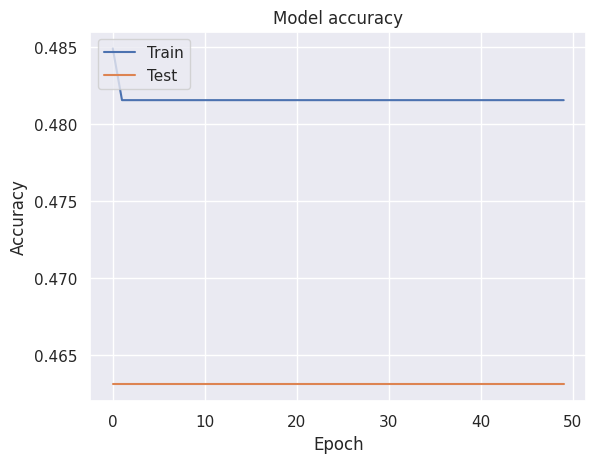

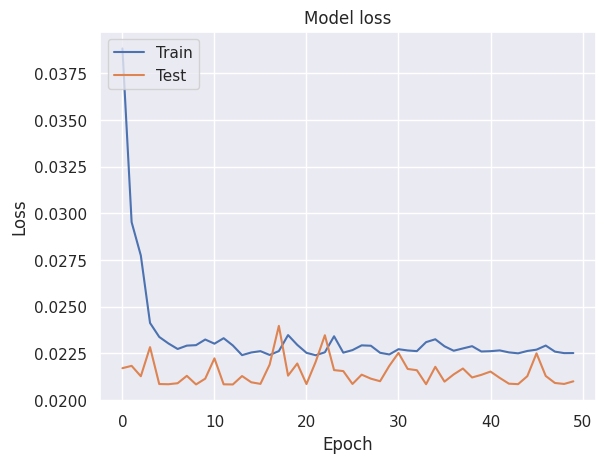

In [45]:
# Plot training & validation accuracy values
plt.plot(history.history['classification_output_accuracy'])
plt.plot(history.history['val_classification_output_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['regression_output_loss'])
plt.plot(history.history['val_regression_output_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## 4.3 Investor-Centric Evaluation

# Section 5: Final Stages

## 5.1 Dynamic Adaptability Testing

## 5.2 Performance Measurement/Metrics

